In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from sklearn.model_selection import cross_validate, cross_val_score
from math import pi
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [320]:
# 0. Load Data and Drop Duplicates
data = pd.read_csv('../raw_data/datos.csv', delimiter = ';', low_memory = False)
data.drop_duplicates(inplace = True)
outliers = data.query('duracion_baja >= 100')  # Save outliers for analysis.
data = data.query('duracion_baja < 100')
# data.drop_duplicates(inplace = True)

# 1. Handle Null Values
# CNAE (only 482)
data = data.query('cnae != 0')

# CodiPostal (Most Frequent)
data['codipostal'] = data['codipostal'].replace('-', (data['codipostal']).mode()[0])

# Contracte (Delete few wrongs and then Most Frequent)
data = data[data['contracte'] != '001']
data = data[data['contracte'] != '019']
data = data[data['contracte'] != '999']

mf_contracte = data['contracte'].mode()[0]
data['contracte'] = data['contracte'].replace('000', mf_contracte).replace('-', mf_contracte)

# Grupcoti (Most Frequent)
mf_grupcoti = data['grupcoti'].mode()[0]
data['grupcoti'] = data['grupcoti'].replace('-', mf_grupcoti).replace('0', mf_grupcoti)

# 2. Data Cleaning
# ContadorBajasCCC (non-sense)
data.drop('ContadorBajasCCC', axis = 1, inplace = True)

# ContadorBajasDNI vs ContadordiasBajasDNI
data = data.query('ContadorBajasDNI <= ContadordiasBajasDNI')

# Categorize CNAE
c = pd.read_excel('Tabla_cnae.xlsx', usecols = ['GRUPO', 'COD_CNAE2009'])
c.rename(columns = {'GRUPO': 'cnae_cat', 'COD_CNAE2009': 'cnae'}, inplace = True)
c['cnae_cat'] = c['cnae_cat'].map(lambda x: ord(x) - 64)
c = c.query('cnae.str.isnumeric()').astype('int')
data = data.merge(c, how = 'left', on = 'cnae')

# Sickness Types
block_ends = [140,240,280,290,320,390,460,520,580,630,680,710,740,760,780,800,1000]
blocks = [[i+1, s] for i, s in enumerate(block_ends)]
special_cases = ['E','V','M']

def make_icd9_cat(row):
    first_str = row.icd9[0]
    if first_str == 'E':
        return 18
    if first_str == 'V':
        return 19
    if first_str == 'M':
        return 20
    else:
        code = float(row.icd9)
        for block in blocks:
            if code < block[1]:
                return block[0]
data['icd9_cat'] = data.apply(lambda row: make_icd9_cat(row), axis=1)

# Sickness Wrong Values
data = data.query('sexo != 1 | icd9_cat != 11')
data = data[~((data['sexo'] == 1) & (data['icd9'].str[:2].isin(['61', '62'])))]
data = data[~((data['sexo'] == 2) & (data['icd9'].str[:2] == '60'))]

# Post Code Categories.
data['codipostal_cat'] = data['codipostal'].str[:2]

# Time in company
# Add 0.01 to have the upper limit. (0.00 means up to 3 days)
data['proporcion_baja'] = (data['duracion_baja'] / (365 * (data['tiempo_en_empresa'] + 0.01)))
by_wrong_proportion = data.sort_values(by = 'proporcion_baja', axis = 0, ascending = False)
data = data.query('proporcion_baja <= 1')
data.drop('proporcion_baja', axis = 1, inplace = True)

# Month not required
data.drop('mes_baja', axis = 1, inplace = True)

# Cyclic Calendar
# data['time'] = (2 * pi * (data['epiweek'] - 1) + ((data['diasemana'] - 1) / 7)) / 52
# data['sin_time'] = np.sin(data['time'])
# data['cos_time'] = np.cos(data['time'])
# data.drop(['time', 'diasemana', 'epiweek'], axis = 1, inplace = True)

# 3. Prepare Data for ML
data.drop(['cnae', 'icd9', 'codipostal', 'contracte'], axis = 1, inplace = True)



/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [317]:
data

,ContadorBajasDNI,sexo,recaida,numtreb,ContadordiasBajasDNI,grupcoti,pluriempleo,diasemana,tiempo_en_empresa,edad,duracion_baja,epiweek,cnae_cat,icd9_cat,codipostal_cat
0,30,2,0,3187,224,2,0,7,0.51,27.2,2,51,8,1,08
1,5,2,0,3187,12,2,0,4,1.41,31.8,1,52,8,16,39
2,17,2,0,3187,46,2,0,4,0.54,20.5,1,52,8,8,38
3,16,2,0,3187,49,2,0,4,2.53,30.6,3,52,8,8,08
4,7,1,0,3187,548,1,0,5,6.16,32.4,2,52,8,8,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231012,9,2,0,8,21,10,0,7,1.99,44.9,1,53,14,16,08
231013,13,2,0,0,223,7,1,7,9.68,45.1,1,53,18,9,08
231014,13,2,0,0,223,8,1,7,3.75,45.1,1,53,9,9,08
231015,1,2,0,1,1,8,0,7,4.26,36.5,1,53,20,1,08


In [318]:
data[(data['ContadorBajasDNI']>25)].count() + data[(data['numtreb']>3200)].count() + data[(data['ContadordiasBajasDNI']>750)].count()

ContadorBajasDNI        3409
sexo                    3409
recaida                 3409
numtreb                 3409
ContadordiasBajasDNI    3409
grupcoti                3409
pluriempleo             3409
diasemana               3409
tiempo_en_empresa       3409
edad                    3409
duracion_baja           3409
epiweek                 3409
cnae_cat                3409
icd9_cat                3409
codipostal_cat          3409
dtype: int64

In [321]:
data.drop(data[(data['ContadorBajasDNI']>25)].index, axis = 0, inplace = True)
data.drop(data[(data['numtreb']>3200)].index, axis = 0, inplace = True)
data.drop(data[(data['ContadordiasBajasDNI']>750)].index, axis = 0, inplace = True)

In [322]:
sample = data.sample(n = 40000, random_state = 8)

In [325]:
sample

,ContadorBajasDNI,sexo,recaida,numtreb,ContadordiasBajasDNI,grupcoti,pluriempleo,diasemana,tiempo_en_empresa,edad,duracion_baja,epiweek,cnae_cat,icd9_cat,codipostal_cat
92385,2,2,0,63,2,7,0,4,1.52,30.0,37,10,3,10,25
188227,2,2,0,2,52,5,0,5,12.79,51.1,3,5,7,8,08
160076,1,2,0,8,1,7,0,5,0.03,20.3,2,7,14,8,46
214550,5,2,0,10,19,7,0,4,14.58,49.6,32,15,7,9,08
109145,1,1,0,62,1,9,0,5,2.63,59.5,2,3,3,8,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216823,19,1,0,61,286,9,0,5,4.65,41.2,2,17,3,16,08
46348,1,2,0,44,1,10,0,2,0.35,17.9,1,45,15,8,08
47623,2,1,0,210,6,8,0,2,4.20,44.3,33,40,3,13,08
131867,8,2,0,11,137,5,0,7,14.05,48.4,24,29,16,16,28


In [328]:

X_train, X_test, y_train, y_test = train_test_split(
                        sample.drop('duracion_baja', axis = 1), sample['duracion_baja'], test_size=0.3)

def prepare_data(X_train, X_test):
    # One hot Encode Categorical Features.
    ohe_cols = ['sexo', 'recaida', 'grupcoti', 'pluriempleo',
                'cnae_cat', 'icd9_cat', 'codipostal_cat']
    for col in ohe_cols:
        ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
        ohe.fit(X_train[[col]])
        for X_t in [X_train, X_test]:
            X_t[ohe.get_feature_names_out()] = ohe.transform(X_t[[col]])
            X_t.drop(col, axis = 1, inplace = True)


    # Scale numerical features.
    robust_cols = ['ContadorBajasDNI', 'ContadordiasBajasDNI', 'numtreb', 'tiempo_en_empresa']
    for col in robust_cols:
        rb_scaler = RobustScaler()
        rb_scaler.fit(X_train[[col]])
        for X_t in [X_train, X_test]:
            X_t[col] = rb_scaler.transform(X_t[[col]])

    standard_cols = ['edad', 'diasemana', 'epiweek']
    for col in standard_cols:   
        st_scaler = StandardScaler()
        st_scaler.fit(X_train[[col]])
        for X_t in [X_train, X_test]:
            X_t[col] = st_scaler.transform(X_t[[col]])
        

    return X_train, X_test

In [329]:
X_train_p, X_test_p = prepare_data(X_train, X_test)

In [330]:
y_log_train = np.log(y_train)
y_log_test = np.log(y_test)

In [331]:
model_LR_1 = LinearRegression()
cv_results_LR_1 = cross_validate(model_LR_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
LR_val_rmse = np.exp(cv_results_LR_1['test_neg_root_mean_squared_error'].mean()*(-1))
LR_val_r2 = cv_results_LR_1['test_r2'].mean()

model_LR_1.fit(X_train_p, y_log_train)
y_pred_LR_1 = model_LR_1.predict(X_test_p)
LR_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_LR_1, squared = False))

print(f'Validation R2= {np.round(LR_val_r2, 2)}, validation rmse= {np.round(LR_val_rmse, 2)}, and training rmse= {np.round(LR_train_rmse, 2)}')

/var/folders/jt/ljcpcwg95nv566n6vzs4822m0000gn/T/ipykernel_4572/1667108410.py:9: RuntimeWarning: overflow encountered in exp
  LR_val_rmse = np.exp(cv_results_LR_1['test_neg_root_mean_squared_error'].mean()*(-1))


Validation R2= -91513511177238.84, validation rmse= inf, and training rmse= 3.08


In [332]:
model_SGD_1 = SGDRegressor(loss='squared_error', alpha = 0.0001, max_iter = 1000, learning_rate = "invscaling", eta0 = 0.01)
cv_results_SGD_1 = cross_validate(model_SGD_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
SGD_val_rmse = np.exp(cv_results_SGD_1['test_neg_root_mean_squared_error'].mean()*(-1))
SGD_val_r2 = cv_results_SGD_1['test_r2'].mean()

model_SGD_1.fit(X_train_p, y_log_train)
y_pred_SGD_1 = model_SGD_1.predict(X_test_p)
SGD_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_SGD_1, squared = False))

print(f'Validation R2= {np.round(SGD_val_r2, 2)}, validation rmse= {np.round(SGD_val_rmse, 2)}, and training rmse= {np.round(SGD_train_rmse, 2)}')

Validation R2= 0.27, validation rmse= 3.08, and training rmse= 3.09


In [333]:
model_RF_1 = RandomForestRegressor(n_estimators=  750, min_samples_leaf= 4, min_samples_split= 10, n_jobs= -1, random_state=0)

In [334]:
cv_results_RF_1 = cross_validate(model_RF_1, X_train_p, y_log_train, cv=2,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
RF_val_rmse = np.exp(cv_results_RF_1['test_neg_root_mean_squared_error'].mean()*(-1))
RF_val_r2 = cv_results_RF_1['test_r2'].mean()

model_RF_1.fit(X_train_p, y_log_train)
y_pred_RF = model_RF_1.predict(X_test_p)
RF_test_rmse = np.exp(mean_squared_error(y_log_test, y_pred_RF, squared = False))

print(f'Validation R2= {np.round(RF_val_r2, 2)}, validation rmse= {np.round(RF_val_rmse, 2)}, and testing rmse= {np.round(RF_test_rmse, 2)}')

Validation R2= 0.31, validation rmse= 2.98, and training rmse= 2.95


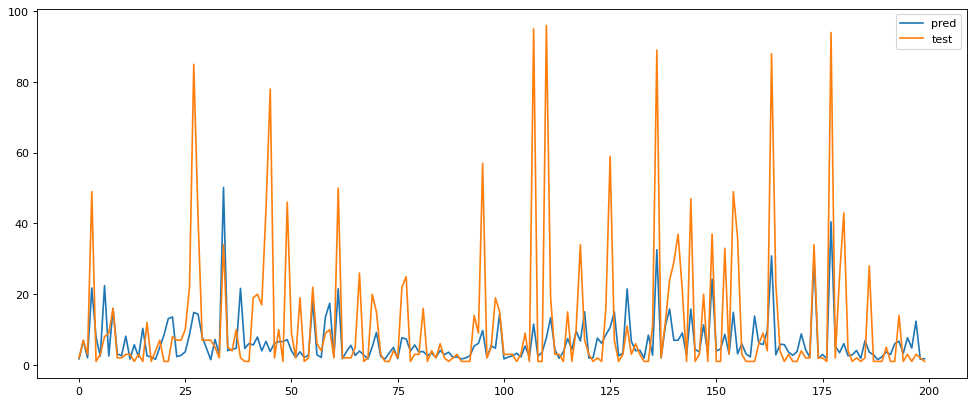

In [335]:
figure(figsize=(15, 6), dpi=80)
plt.plot(np.exp(y_pred_RF[1000:1200]), label = 'pred')
plt.plot(np.array(y_test)[1000:1200], label = 'test')
plt.legend()

In [338]:
model_xgb_1 = xgb.XGBRegressor(booster= 'dart', objective ='reg:squarederror', n_estimators = 750, learning_rate= 0.01,
                               min_child_weight= 4, max_depth= 8, colsample_bytree= 0.7, n_jobs=-1)

In [339]:
# XGB_val_r2 = cross_val_score(model_xgb_1, X_train_p, y_log_train, scoring='r2', cv=5).mean()
# XGB_val_rmse = cross_val_score(model_xgb_1, X_train_p, y_log_train, scoring='neg_root_mean_squared_error', cv=5).mean()*(-1)

model_xgb_1.fit(X_train_p, y_log_train)
y_pred_xgb = model_xgb_1.predict(X_test_p)
# XGB_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_xgb, squared = False))

# print(f'Validation R2= {np.round(XGB_val_r2, 2)}, validation rmse= {np.round(XGB_val_rmse, 2)}, and training rmse= {np.round(XGB_train_rmse, 2)}')
model_xgb_1.score(X_test_p, y_log_test)

0.330691759415193

In [340]:
y_pred_xgb = model_xgb_1.predict(X_test_p)

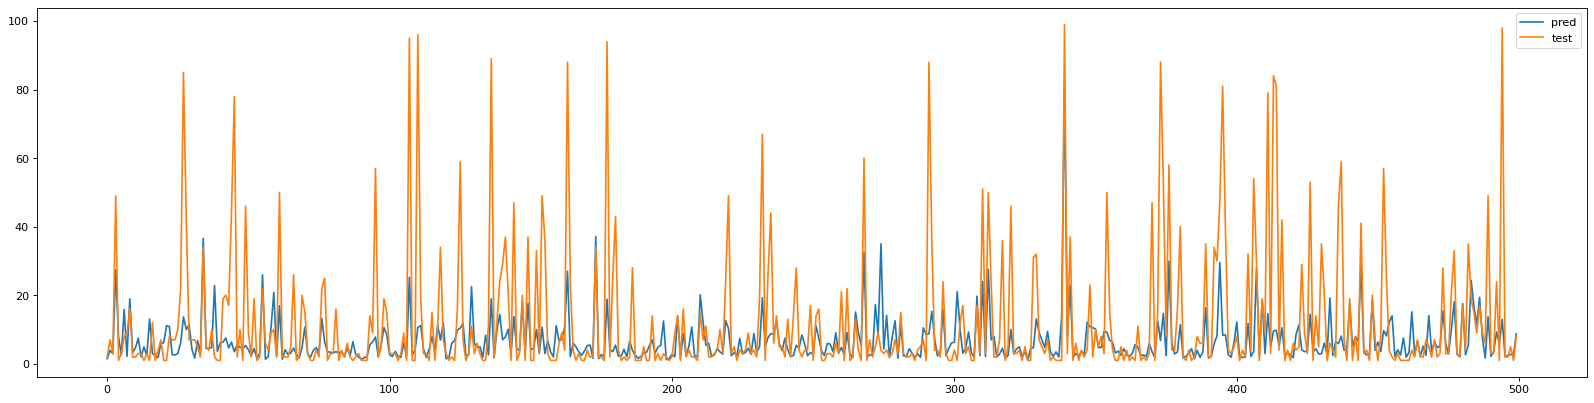

In [345]:
figure(figsize=(25, 6), dpi=80)
plt.plot(np.exp(y_pred_xgb[1000:1500]), label = 'pred')
plt.plot(np.array(y_test)[1000:1500], label = 'test')
plt.legend()

In [50]:
model_KNR_1 = KNeighborsRegressor(n_neighbors = 20, leaf_size = 40)
cv_results_KNR_1 = cross_validate(model_KNR_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
)

KNR_val_rmse = np.exp(cv_results_KNR_1['test_neg_root_mean_squared_error'].mean()*(-1))
KNR_val_r2 = cv_results_KNR_1['test_r2'].mean()

model_KNR_1.fit(X_train_p, y_log_train)
y_pred_KNR_1 = model_KNR_1.predict(X_test_p)
KNR_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_KNR_1, squared = False))

print(f'Validation R2= {np.round(KNR_val_r2, 2)}, validation rmse= {np.round(KNR_val_rmse, 2)}, and training rmse= {np.round(KNR_train_rmse, 2)}')

Validation R2= 0.26, validation rmse= 3.53, and training rmse= 3.48


In [52]:
model_ridge_1 = Ridge()
cv_results_ridge_1 = cross_validate(model_ridge_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
pd.DataFrame(cv_results_ridge_1)
ridge_val_rmse = np.exp(cv_results_ridge_1['test_neg_root_mean_squared_error'].mean()*(-1))
ridge_val_r2 = cv_results_ridge_1['test_r2'].mean()

model_ridge_1.fit(X_train_p, y_log_train)
y_pred_ridge_1 = model_ridge_1.predict(X_test_p)
ridge_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_ridge_1, squared = False))

print(f'Validation R2= {np.round(ridge_val_r2, 2)}, validation rmse= {np.round(ridge_val_rmse, 2)}, and training rmse= {np.round(ridge_train_rmse, 2)}')

Validation R2= 0.31, validation rmse= 3.39, and training rmse= 3.38


In [57]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_dim=114))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1150      
                                                                 
 dense_1 (Dense)             (None, 64)                704       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,967
Trainable params: 3,967
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(loss='mse', optimizer = 'adam', metrics='RootMeanSquaredError')

In [63]:
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_p, y_log_train, validation_split=0.3, callbacks = [es], epochs = 100, verbose = 0)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


In [64]:
res_NN = model.evaluate(X_test_p, y_log_test)[1]

375/375 [==============================] - 0s 489us/step - loss: 1.3926 - root_mean_squared_error: 1.1801


In [65]:
y_pred_NN = model.predict(X_test_p)

375/375 [==============================] - 0s 349us/step


In [66]:
np.exp(mean_squared_error(y_log_test, y_pred_NN, squared = False))

3.254623238040044

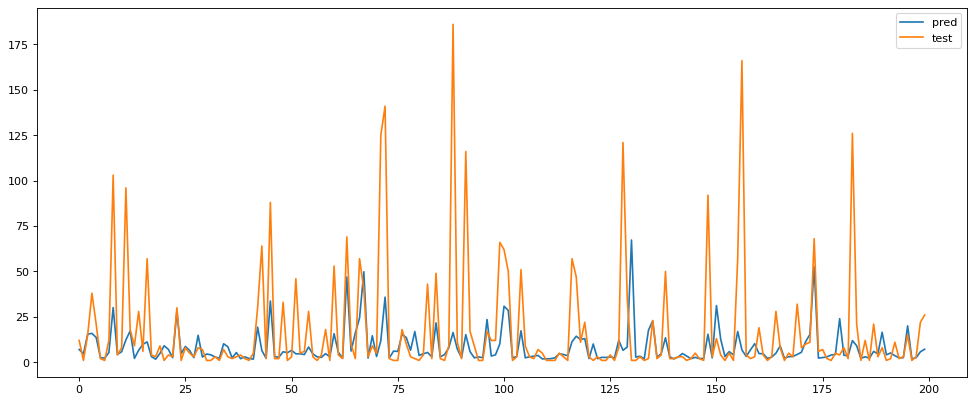

In [67]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)
# figzise = (100, 50)
plt.plot(np.exp(y_pred_NN[1000:1200]), label = 'pred')
plt.plot(np.array(y_test)[1000:1200], label = 'test')
plt.legend()

In [69]:
model_RF = RandomForestRegressor()
# Hyperparameter Grid
RF_grid = {'n_estimators': [600, 1500],
        'min_samples_split': [10, 15, 50],
        'min_samples_leaf': [4, 6]}
# Instanciate Grid Search
RF_search = GridSearchCV(model_RF, RF_grid,
                           scoring = 'r2',
                           cv = 3,
                           n_jobs=-1 # paralellize computation
                           )

# Fit data to Grid Search
RF_search.fit(X_train_p, y_log_train)

print(RF_search.best_score_)
print(RF_search.best_params_)
print(RF_search.best_estimator_)

0.35751170497700846
{'min_samples_leaf': 4, 'min_samples_split': 50, 'n_estimators': 1500}
RandomForestRegressor(min_samples_leaf=4, min_samples_split=50,
                      n_estimators=1500)


In [72]:
model_RF = RandomForestRegressor()
# Hyperparameter Grid
RF_grid = {'n_estimators': [600, 1500],
        'min_samples_split': [10, 15, 50],
        'min_samples_leaf': [4, 6]}
# Instanciate Grid Search
RF_search_2 = RandomizedSearchCV(model_RF, RF_grid,
                           scoring = 'r2',
                           cv = 3,
                           n_jobs=-1 # paralellize computation
                           )

# Fit data to Grid Search
RF_search_2.fit(X_train_p, y_log_train)

print(RF_search_2.best_score_)
print(RF_search_2.best_params_)
print(RF_search_2.best_estimator_)

0.3576410632397629
{'n_estimators': 1500, 'min_samples_split': 50, 'min_samples_leaf': 4}
RandomForestRegressor(min_samples_leaf=4, min_samples_split=50,
                      n_estimators=1500)


In [73]:
model_XGB_2 = xgb.XGBRegressor()
parameters_XGB = {'nthread':[4, 6], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.03], #so called `eta` value
              'max_depth': [7, 8, 10],
              'min_child_weight': [4, 6],
              'subsample': [0.7, 0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 750]}

xgb_grid = GridSearchCV(model_XGB_2,
                        parameters_XGB,
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train_p, y_log_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.38602885880855003
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 750, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}


In [78]:


# Instanciate model
model_XGB = xgb.XGBRegressor() # Hyperparameter Grid
grid_XGB = {'booster': ['dart'],
            'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01], #so called `eta` value
              'max_depth': [8, 10],
              'min_child_weight': [4],
              'colsample_bytree': [0.7],
              'n_estimators': [750]}

# {'booster': ['gbtree', 'gblinear'],
#               'nthread':[4, 6], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.001, 0.01], #so called `eta` value
#               'max_depth': [10, 20],
#               'colsample_bytree': [0.9, 1],
#               'n_estimators': [250, 500]}

# Instanciate Grid Search
search_XGB = RandomizedSearchCV(model_XGB, grid_XGB, scoring='r2')
# Fit data to Grid Search
search_XGB.fit(X_train_p, y_log_train)
print(search_XGB.best_estimator_)
print(search_XGB.best_score_)
print(search_XGB.best_params_)

[17:53:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xg

In [61]:
X_train_2 = pd.read_csv('../raw_data/optim_12_05_10-00/X_train_p')
X_train_2.drop(columns='Unnamed: 0', inplace = True)
X_test_2 = pd.read_csv('../raw_data/optim_12_05_10-00/X_test_p')
X_test_2.drop(columns='Unnamed: 0', inplace = True)
y_train_2 = pd.read_csv('../raw_data/optim_12_05_10-00/y_train')
y_train_2.drop(columns='Unnamed: 0', inplace = True)
y_test_2 = pd.read_csv('../raw_data/optim_12_05_10-00/y_test')
y_test_2.drop(columns='Unnamed: 0', inplace = True)


In [17]:
df_train_2 = pd.concat((X_train_2, y_train_2), axis = 1)
df_test_2 = pd.concat((X_test_2, y_test_2), axis = 1)

In [18]:
df_train_opt = df_train_2.sample(n = 40000, random_state = 8)
df_test_opt = df_test_2.sample(n = 20000, random_state = 8)


In [19]:
X_train_opt = df_train_opt.drop(columns = 'duracion_baja')
y_train_opt = df_train_opt['duracion_baja']
X_test_opt = df_test_opt.drop(columns = 'duracion_baja')
y_test_opt = df_test_opt['duracion_baja']

In [255]:
y_log_train_opt = np.log(y_train_opt)
y_log_test_opt = np.log(y_test_opt)

In [256]:
cv_results_RF_opt = cross_validate(model_RF_1, X_train_opt, y_log_train_opt, cv=2,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
RF_val_rmse_opt = np.exp(cv_results_RF_opt['test_neg_root_mean_squared_error'].mean()*(-1))
RF_val_r2_opt = cv_results_RF_opt['test_r2'].mean()

model_RF_1.fit(X_train_opt, y_log_train_opt)
y_pred_RF_opt = model_RF_1.predict(X_test_opt)
RF_train_rmse_opt = np.exp(mean_squared_error(y_log_test_opt, y_pred_RF_opt, squared = False))

print(f'Validation R2= {np.round(RF_val_r2_opt, 2)}, validation rmse= {np.round(RF_val_rmse_opt, 2)}, and training rmse= {np.round(RF_train_rmse_opt, 2)}')

Validation R2= 0.32, validation rmse= 3.35, and training rmse= 3.33


In [78]:
XGB_val_r2_opt = cross_val_score(model_xgb_1, X_train_opt, y_log_train_opt, scoring='r2', cv=5).mean()
XGB_val_rmse_opt = cross_val_score(model_xgb_1, X_train_opt, y_log_train_opt, scoring='neg_root_mean_squared_error', cv=5).mean()*(-1)

model_xgb_1.fit(X_train_opt, y_log_train_opt)
y_pred_xgb_opt = model_xgb_1.predict(X_test_opt)
XGB_train_rmse_opt = np.exp(mean_squared_error(y_log_test_opt, y_pred_xgb_opt, squared = False))

print(f'Validation R2= {np.round(XGB_val_r2_opt, 2)}, validation rmse= {np.round(XGB_val_rmse_opt, 2)}, and training rmse= {np.round(XGB_train_rmse_opt, 2)}')

KeyboardInterrupt: 

In [250]:
cv_results_RF_opt = cross_validate(model_RF_1, X_train_opt, y_log_train_opt, cv=2,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
RF_val_rmse_opt = np.exp(cv_results_RF_opt['test_neg_root_mean_squared_error'].mean()*(-1))
RF_val_r2_opt = cv_results_RF_opt['test_r2'].mean()

model_RF_1.fit(X_train_opt, y_log_train_opt)
y_pred_RF_opt = model_RF_1.predict(X_test_opt)
RF_train_rmse_opt = np.exp(mean_squared_error(y_log_test_opt, y_pred_RF_opt, squared = False))

print(f'Validation R2= {np.round(RF_val_r2_opt, 2)}, validation rmse= {np.round(RF_val_rmse_opt, 2)}, and training rmse= {np.round(RF_train_rmse_opt, 2)}')

Validation R2= 0.32, validation rmse= 3.25, and training rmse= 3.24


In [64]:
def y_encode_10(y):
    if y<2:
        return 1
    elif y<5:
        return 2
    elif y<10:
        return 3
    elif y<15:
        return 4
    elif y<25:
        return 5
    elif y<50:
        return 6
    elif y<75:
        return 7
    else:
        return 8

In [65]:
def y_encode_2(y):
    if y<15:
        return 0
    else:
        return 1

In [66]:
def y_encode_3(y):
    if y<3:
        return 0
    if y<15:
        return 2
    else:
        return 1

In [71]:
y_train_encoded = y_train_opt.map(lambda x: y_encode_2(x))

In [72]:
y_test_encoded = y_test_opt.map(lambda x: y_encode_2(x))

In [52]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(max_iter=500)
model_log.fit(X_train_opt, y_train_encoded)
model_log.score(X_test_opt, y_test_encoded)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.51745

In [53]:
from sklearn.ensemble import RandomForestClassifier
model_RFC = RandomForestClassifier(n_estimators= 300, criterion= 'entropy', min_samples_split= 10, max_depth= 100)
model_RFC.fit(X_train_opt, y_train_encoded)
model_RFC.score(X_test_opt, y_test_encoded)

0.5406

In [358]:
grid_RFC = {'n_estimators': [200, 300],
            'criterion': ['entropy'],
            'min_samples_split': [10, 15],
            'max_depth': [50, 75]
            }
# Instanciate Grid Search
search_RFC = RandomizedSearchCV(model_RFC, grid_RFC, scoring='accuracy', n_jobs = -1, cv = 3)
# Fit data to Grid Search
search_RFC.fit(X_train_opt, y_train_encoded)
print(search_RFC.best_estimator_)
print(search_RFC.best_score_)
print(search_RFC.best_params_)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestClassifier(criterion='entropy', max_depth=75, min_samples_split=10,
                       n_estimators=300)
0.7776749859724443
{'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 75, 'criterion': 'entropy'}


In [73]:
model_XGBC = xgb.XGBClassifier(objective= 'reg:logistic', max_depth= 3)#, num_class= 2)

In [74]:
model_XGBC.fit(X_train_opt, y_train_encoded)
model_XGBC.score(X_test_opt, y_test_encoded)

0.78415

In [371]:
grid_XGBC = {
        'min_child_weight': [1],
        'gamma': [1.5, 3],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6],
        'max_depth': [3, 10]
        }
# Instanciate Grid Search
search_XGBC = GridSearchCV(model_XGBC, grid_XGBC, scoring='accuracy', n_jobs = -1, cv = 2)
# Fit data to Grid Search
search_XGBC.fit(X_train_opt, y_train_encoded)
print(search_XGBC.best_estimator_)
print(search_XGBC.best_score_)
print(search_XGBC.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:hinge',
              predictor='auto', ...)
0.770425
{'colsample_bytree': 0.6, 'gamma': 3, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}


In [306]:
from sklearn.neighbors import KNeighborsClassifier
model_KNC = KNeighborsClassifier()
model_KNC.fit(X_train_opt, y_train_encoded)
model_KNC.score(X_test_opt, y_test_encoded)

0.57175

In [299]:
from sklearn.svm import SVC
model_SVC = SVC()
model_SVC.fit(X_train_opt, y_train_encoded)
model_SVC.score(X_test_opt, y_test_encoded)

0.7582

In [56]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_opt, y_train_encoded)

In [49]:
y_train_resampled

0        0
1        1
2        0
3        1
4        0
        ..
57067    1
57068    1
57069    1
57070    1
57071    1
Name: duracion_baja, Length: 57072, dtype: int64

In [57]:
from sklearn.linear_model import LogisticRegression
model_LR_2 = LogisticRegression(max_iter=500)
model_LR_2.fit(X_train_resampled, y_train_resampled)
model_LR_2.score(X_test_opt, y_test_encoded)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.51385

In [58]:
from sklearn.ensemble import RandomForestClassifier
model_RFC = RandomForestClassifier(n_estimators= 300, criterion= 'entropy', min_samples_split= 10, max_depth= 100)
model_RFC.fit(X_train_resampled, y_train_resampled)
model_RFC.score(X_test_opt, y_test_encoded)

0.5388

In [59]:
model_XGBC = xgb.XGBClassifier(objective= 'reg:logistic', max_depth= 3)
model_XGBC.fit(X_train_resampled, y_train_resampled)
model_XGBC.score(X_test_opt, y_test_encoded)

0.54685

In [63]:
X_train_3 = pd.read_csv('../raw_data/optim_12_06_10-45/X_train')
X_test_3 = pd.read_csv('../raw_data/optim_12_06_10-45/X_test')
y_train_3 = pd.read_csv('../raw_data/optim_12_06_10-45/y_train')
y_test_3 = pd.read_csv('../raw_data/optim_12_06_10-45/y_test')

In [67]:
df_train_3 = pd.concat((X_train_3, y_train_3), axis = 1)
df_test_3 = pd.concat((X_test_3, y_test_3), axis = 1)
df_train_3_opt = df_train_3.sample(n = 40000, random_state = 8)
df_test_3_opt = df_test_3.sample(n = 20000, random_state = 8)
X_train_3_opt = df_train_3_opt.drop(columns = 'duracion_baja')
y_train_3_opt = df_train_3_opt['duracion_baja']
X_test_3_opt = df_test_3_opt.drop(columns = 'duracion_baja')
y_test_3_opt = df_test_3_opt['duracion_baja']

In [68]:
y_train_3_encoded = y_train_3_opt.map(lambda x: y_encode_2(x))
y_test_3_encoded = y_test_3_opt.map(lambda x: y_encode_2(x))

In [69]:
from sklearn.linear_model import LogisticRegression
model_LR_3 = LogisticRegression(max_iter=500)
model_LR_3.fit(X_train_3_opt, y_train_3_encoded)
model_LR_3.score(X_test_3_opt, y_test_3_encoded)

0.7079

In [70]:
model_XGBC_3 = xgb.XGBClassifier(objective= 'reg:logistic', max_depth= 3)
model_XGBC_3.fit(X_train_3_opt, y_train_3_encoded)
model_XGBC_3.score(X_test_3_opt, y_test_3_encoded)

0.79635

In [ ]:
y_train_3_encoded.sum()

In [75]:
from imblearn.over_sampling import SMOTE
X_train_3_resampled, y_train_3_resampled = SMOTE().fit_resample(X_train_3_opt, y_train_3_encoded)

In [76]:
model_XGBC_3_SMOTE = xgb.XGBClassifier(objective= 'reg:logistic', max_depth= 3)
model_XGBC_3_SMOTE.fit(X_train_3_resampled, y_train_3_resampled)
model_XGBC_3_SMOTE.score(X_test_3_opt, y_test_3_encoded)

0.79315

In [77]:
y_log_3_train_opt = np.log(y_train_3_opt)
y_log_3_test_opt = np.log(y_test_3_opt)

In [78]:
model_xgb_3 = xgb.XGBRegressor(booster= 'dart', objective ='reg:squarederror', n_estimators = 750, learning_rate= 0.01,
                               min_child_weight= 4, max_depth= 8, colsample_bytree= 0.7, n_jobs=-1)
model_xgb_3.fit(X_train_3_opt, y_log_3_train_opt)
y_pred_3_xgb = model_xgb_3.predict(X_test_3_opt)
model_xgb_3.score(X_test_3_opt, y_log_3_test_opt)

0.44955795488824224